# w1dem.py 最新版
日付：2018/11/20<br>
## できること
1. 周波数領域<br>
    VMD<br>
    Loop
2. 時間領域<br>
    VMD（インパルス、ステップ）
    

## 未実装項目（実装予定）
1. 時間領域<br>
    Loop<br>
    Coincident
saitouikuya



In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.special import erf
import math
%matplotlib inline

In [81]:
EmB = {'x': 0,
       'y': 0,
       'z': 0,
       'rad': 10,
       'bRes': np.array([100,100]),
       'dh': np.array([20]),
       'mu': np.array([1.2566e-06,1.2566e-06]),
       'mu0': 1.2566e-06,
       'epsrn': 0,
       'hs': 1.0000e-08,
       'current': 1,
       'vmd': 1,
       'turns': 1,
       'srcpar': 2,
       'fdtd': 1,
       'dbdt': 1,
       # 1: Ex, 2: Ey, 3:Ez, 4:Hx, 5:Hy, 6:Hz
       'rComp': [1, 2, 3, 4, 5],
       'temtype': 1,
       'tol': 1.0000e-12,
       'NB': 0,
       'BMAX': 0,
       'numF': 100,
       'SwHankel': 1,
       'mom': 1,
       'nLayer': 2,
       'rLayer': 0,
       'ii': 0,
       'time_point':100,
       #Lはラプラス変換の係数の個数。倍精度では12が最も精度が高いとされている
       'L':10
}
EmB['f'] = np.logspace(-2, 6, EmB["numF"])
EmB["sigma"] = 1 / EmB["bRes"]
EmB["r"] = np.sqrt(EmB["x"]**2 + EmB["y"]**2)
# EmB["time"] = np.logspace(-10, -2, EmB["time_point"])

In [82]:
def inverse_laplace_coefficient(L):
    v = np.zeros(L)
    nn2 = L / 2
    nn21 = nn2 + 1
    for n in range(1, L + 1):
        z = 0.0
        for k in range(math.floor((n + 1) / 2), int(min(n, nn2) + 1)):
            numerator = (k ** nn2) * math.factorial(2 * k)
            denominator = math.factorial(nn2 - k) * math.factorial(k) * math.factorial(k - 1) * math.factorial(n - k) * math.factorial(2 * k - n)
            z = z + numerator / denominator

        v[n - 1] = (-1) ** (n + nn2) * z
    return v

In [83]:
def make_kernel(omega, nLayer, filter_length, yBase, r, rad):
    # hankel変換で用いるカーネルを作る
    k = (omega**2.0 * mu * epsrn - 1j * omega * mu * sigma) ** 0.5
    if srcpar == 1:
        lamda = yBase / r
    elif (srcpar == 2) or (srcpar == 3):
        lamda = yBase / rad
    
    # set k and u in the air(epsiron ~= 0, sigma ~= 0)
    k0 = 0
    u0 = lamda

    u = np.zeros((nLayer, filter_length, 1),dtype=np.complex)

    for ii in range(nLayer):
        u[ii] = ((lamda**2 - k[ii]**2)**0.5).reshape((filter_length, 1))

    tanhuh = np.zeros((nLayer - 1, filter_length, 1),dtype=np.complex)

    for ii in range(nLayer - 1):
        tanhuh[ii] = np.tanh(u[ii] * dh[ii])

    zHat0 = 1j * omega * mu[0]
    Y0 = u0 / zHat0
    zHat = 1j * omega * mu
    Y = np.zeros((nLayer, filter_length, 1),dtype=np.complex)
    YHat = np.zeros((nLayer, filter_length, 1),dtype=np.complex)

    for ii in range(nLayer):
        Y[ii] = u[ii]/zHat[ii]

    YHat[nLayer - 1, :, 0] = Y[nLayer - 1, :, 0]

    if nLayer >= 2:
        numerator = YHat[nLayer - 1, :, 0] + Y[nLayer - 2, :, 0] * tanhuh[nLayer - 2, :, 0]
        denominator = Y[nLayer - 2, :, 0] + YHat[nLayer - 1, :, 0] * tanhuh[nLayer - 2, :, 0]
        YHat[nLayer - 2, :, 0] = Y[nLayer - 2, :, 0] * numerator / denominator

        if nLayer >= 3:
            for ii in range(nLayer - 2, 0, -1):
                numerator = YHat[ii, :, 0] + Y[ii - 1, :, 0] * tanhuh[ii - 1, :, 0]
                denominator = Y[ii - 1, :, 0] + YHat[ii, :, 0] * tanhuh[ii, :, 0]
                YHat[ii - 1, :, 0] = Y[ii - 1, :, 0] * numerator / denominator

    elif nLayer ==  1:
        print("nothing")
        #1層のとき、特になにもなし

    GammaTE = ((Y0 - YHat[0, : , 0].reshape(filter_length, 1)) / (Y0 + YHat[0, :, 0].reshape(filter_length, 1)))
    eUp = np.exp(-u0 * (z + hs))
    eDown = np.exp(u0 * (z - hs))

    if srcpar == 1:
        kernelEphai = (eUp + GammaTE * eDown) * lamda**2/u0
        kernelHr = (eUp - GammaTE * eDown) * lamda**2
        kernelHz = kernelEphai * lamda
        return {"kernelEphai": kernelEphai, "kernelHr": kernelHr, "kernelHz": kernelHz, "zHat0": zHat0}
    elif srcpar >= 2:
        besk1 = scipy.special.jn(1, lamda * r)
        besk0 = scipy.special.jn(0, lamda * r)
        besk1rad = scipy.special.jn(1, lamda * rad)
        # p.219 eq. 4.86, 4.87, 4.88
        kernelEphai = (eUp + GammaTE * eDown) * lamda * besk1 / u0 
        kernelHr    = (eUp - GammaTE * eDown) * lamda * besk1 
        kernelHz    = (eUp + GammaTE * eDown) * (lamda ** 2) * besk0 / u0
        kernelHzCO  = (eUp + GammaTE * eDown) * lamda * besk1rad / u0
        return {"kernelEphai": kernelEphai, "kernelHr": kernelHr, "kernelHz": kernelHz, "kernelHzCO": kernelHzCO, "zHat0": zHat0}

In [84]:
def hankela1(EmB, yBase, wt0, wt1, **iFrq):
    
    for (key, value) in zip(EmB.keys(), EmB.values()):
        exec("{new_key} = EmB['{key}']".format(key=key, new_key=key),globals())

    #戻り値返すための辞書定義
    hankel_ANS = {}
    if fdtd == 1:
        omega = 2 * np.pi * f[iFrq["iFrq"] - 1]
        kernel = make_kernel(omega, nLayer, filter_length, yBase, r, rad)
        kernelEphai = kernel["kernelEphai"]
        kernelHr = kernel["kernelHr"]
        kernelHz = kernel["kernelHz"]
        kernelHzCO = kernel["kernelHzCO"]
        ePhai = np.dot(wt1.T, kernelEphai)
        hR = np.dot(wt1.T, kernelHr)

        if srcpar == 1:
            hZ = np.dot(wt0.T, kernelHz)
            hankel_ANS["ePhai"] = (-1 * kernel["zHat0"] * ePhai)/(4 * np.pi * r)
            hankel_ANS["hR"] = (hR)/(4 * np.pi * r)
            hankel_ANS["hZ"] = (hZ)/(4 * np.pi * r)

        elif (srcpar == 2) or (srcpar == 3):
            hZ = np.dot(wt1.T, kernelHz)
            hZco = np.dot(wt1.T, kernelHzCO)
            hankel_ANS["ePhai"] = (-1 * kernel["zHat0"] * rad * ePhai) / (2 * rad)
            hankel_ANS["hR"] = (rad * hR) / (2 * rad)
            hankel_ANS["hZ"] = (rad * hZ) / (2 * rad)
            hankel_ANS["hZco"] = (1 * np.pi * (rad ** 2) * hZco) / rad
    
    elif fdtd == 2:
        sum_ = 0.0
        ln2_on_t = np.log(2.0) / time
        if dbdt == 0:   
            for n in range(1, L + 1):
                p = n * ln2_on_t
                omega = p / 1j
                hankel_ANS["omega"] = omega
                kernel = make_kernel(omega, nLayer, filter_length, yBase, r, rad)
                kernelHz = kernel["kernelHz"]
                sum_ = sum_ + v[n - 1] * kernelHz
        elif dbdt == 1:
            for n in range(1, L + 1):
                p = n * ln2_on_t
                omega = p / 1j
                hankel_ANS["omega"] = omega
                kernel = make_kernel(omega, nLayer, filter_length, yBase, r, rad)
                kernelHz = kernel["kernelHz"]
                sum_ = sum_ + v[n - 1] * kernelHz / omega
        if srcpar == 1:
            hZ = np.dot(wt0.T, sum_)
            hankel_ANS["hZ"] = (hZ)/(4 * np.pi * r)
            ilt = ln2_on_t * hankel_ANS["hZ"]
            hankel_ANS["eh"] = ilt 
        elif srcpar == 2:
            hZ = np.dot(wt1.T, sum_)
            hankel_ANS["hZ"] = (rad * hZ) / (rad * 2)
            ilt = ln2_on_t * hankel_ANS["hZ"]
            hankel_ANS["eh"] = ilt
    return hankel_ANS

In [85]:
def em1dbasetdem(EmB):
    global z
    
    for (key, value) in zip(EmB.keys(), EmB.values()):
        exec("{new_key} = EmB['{key}']".format(new_key=key, key=key),globals())
    
    if (srcpar == 1) and (z == 0):
        z = -1e-3
        
    EmB["r"] = np.sqrt(x ** 2 + y ** 2)
    r = np.sqrt(x ** 2 + y ** 2)
    
    if srcpar == 1 and r == 0:
        r = 1e-2
    
    if r != 0.0:
        cosPhai = x / r
        sinPhai = y / r
    else:
        cosPhai = 0
        sinPhai = 0
        
    if srcpar == 1:
        mom = vmd
    elif srcpar == 2:
        mom = current
    elif srcpar == 3:
        mom = current * turns
    
    nLayer = len(bRes)
    h = np.zeros((nLayer - 1, 1))
    mu = np.ones(nLayer) * mu0
    
    if nLayer >= 2:
        h[0] = dh[0]
        
    if z <= 0:
        rLayer = 0
    elif z > 0 and z <= h[0]:
        rLayer = 1
    else:
        rLayer = 2
        
    if nLayer >= 3:
        for ii in range(2, nLayer):
            h[ii - 1] = h[ii - 2] + dh[ii - 1]
            if (z >= h[ii - 2]) and (z <= h[ii - 1]):
                rLayer = ii
    
    if EmB["SwHankel"] == 1:
        #hankel241を読み込む
        print("filter is kong")
        matdata = scipy.io.loadmat("hankelset241.mat")
        EmB["filter_length"] = matdata["lamdaBase"].shape[0]
        wt0 = matdata["j0"]
        wt1 = matdata["j1"]
        lamdaBase = matdata["lamdaBase"]
        yBase = lamdaBase
        
    elif EmB["SwHankel"] == 2:
        print("filter is anderson")
        matdata = scipy.io.loadmat("anderson_801.mat")
        EmB["filter_length"] = matdata["yBase"].shape[0]
        wt0 = matdata["wt0"]
        wt1 = matdata["wt1"]
        lamdaBase = matdata["yBase"]
        yBase = lamdaBase
        
    ePhai = np.zeros(numF, dtype=complex)
    hR = np.zeros(numF, dtype=complex)
    
    if fdtd == 1:
        DANS = np.zeros((numF, 6), dtype=complex)
        
        for iFrq in range(1, numF + 1):
            EmB["ii"] = 0
            emField = hankela1(EmB, yBase, wt0, wt1, iFrq = iFrq)

            #ここ、少し無駄が多い。ディクショナリにもっとわかりやすい形で格納してもいいかも
            ePhai[iFrq - 1] = emField["ePhai"].reshape(1)
            
            DANS[iFrq - 1, 0] = -sinPhai * ePhai[iFrq - 1]
            DANS[iFrq - 1, 1] = cosPhai * ePhai[iFrq - 1]
            
            #2018/1002ここ変更の必要あり。
            hR[iFrq - 1] = emField["hR"]
            
            DANS[iFrq - 1, 3] = cosPhai * hR[iFrq - 1]
            DANS[iFrq - 1, 4] = sinPhai * hR[iFrq - 1]
            DANS[iFrq - 1, 5] = emField["hZ"]
            
            DANS = mom * DANS
            ARG = f
            
        return {"DANS": DANS, "ARG": ARG}
    elif fdtd == 2:
        DANS = np.zeros(time_point, dtype=complex)
        time = np.logspace(-5, 0, time_point)
        v = inverse_laplace_coefficient(L)
        EmB["v"] = v
        for t in range(1, time_point+1):
            EmB["time"] = time[t - 1]
            ilt = hankela1(EmB, yBase, wt0, wt1)
            DANS[t - 1] = ilt["eh"]
            
        return {"DANS": DANS, "ARG": time}

In [86]:
def w1dem(EmB):
    for (key, value) in zip(EmB.keys(), EmB.values()):
        exec("{new_key} = EmB['{key}']".format(key=key, new_key=key),globals())
    
    #数値解
    numerical = em1dbasetdem(EmB)
    if fdtd == 2:
        ARG = numerical["ARG"]
        
    numerical = numerical["DANS"]
    if srcpar == 1:
        #VMD、周波数領域
        if fdtd == 1:
            if dbdt == 1:
                numerical_Ey = numerical[:, 1]
                numerical_Bz = numerical[:, 5]
                omega = 2 * np.pi * f
                k1d = (omega ** 2 * mu0 * epsrn - 1j * omega * mu0 * sigma[0]) ** 0.5

                #解析解の計算
                numerator = - mom * (3 - (3 + 3j * k1d * r - k1d ** 2 * r ** 2) * np.exp(-1j * k1d * r))
                denominator = 2 * np.pi * sigma[0] * r ** 4
                ePhaiHomoSurf = numerator / denominator

                numerator = mom * (9 - (9 + 9j * k1d * r - 4 * k1d ** 2 * r ** 2 - 1j * k1d ** 3 * r ** 3)\
                                   * np.exp(-1j * k1d * r))
                denominator = 2 * np.pi * k1d ** 2 * r ** 5
                hZHomoSurf = numerator / denominator

                #可視化
                Hza = hZHomoSurf
                Era = ePhaiHomoSurf

                fig = plt.figure(figsize=(10,8),dpi=200)
                ax1 = fig.add_subplot(2, 2, 1) 
                ax1.scatter(f, np.abs(np.imag(numerical_Ey)),marker = "x", color = "blue", s = 8, lw = 1)
                ax1.scatter(f, np.abs(np.real(numerical_Ey)), marker = "x", color = "red", s = 8, lw = 1)
                ax1.plot(f, np.abs(np.real(Era)), color = "red")
                ax1.plot(f, np.abs(np.imag(Era)), color = "blue")
                plt.xscale("log")
                plt.yscale("log")
                ax2 = fig.add_subplot(2, 2, 2)
                plt.xscale("log")
                plt.yscale("log")
                ax2.scatter(f, np.abs(np.imag(numerical_Bz)),marker = "x", color = "blue", s = 8, lw = 1)
                ax2.scatter(f, np.abs(np.real(numerical_Bz)), marker = "x", color = "red", s = 8, lw = 1)
                ax2.plot(f, np.abs(np.real(Hza)), color = "red")
                ax2.plot(f, np.abs(np.imag(Hza)), color = "blue")
                plt.show
            
        elif fdtd == 2:
            th = np.sqrt(mu0 / (4 * (ARG) * bRes[0]))
            thx = (4 * ARG) / (mu0 * sigma[0] * (r**2))
            Hz0 = -mom / (4 * np.pi * r**3)
            if dbdt == 0:
                dHz = (mom / (2 * np.pi * mu[0] * sigma[0] * r**5))\
                *(9*erf(th*r) - (2*th*r/(np.pi**0.5))*(9+6*(th**2)*(r**2)+4*(th**4)*(r**4))*np.exp(-(th**2)*(r**2)))
                
                fig = plt.figure(figsize=(10,10),dpi=200)
                ax1 = fig.add_subplot(2, 2, 1)
#                 error = np.abs(np.imag(numerical))/np.abs(np.real(hZa))
                ax1.scatter(ARG, np.abs(np.real(numerical)), marker = "x", color = "red", s = 8, lw = 1)
                ax1.scatter(ARG, np.abs(np.imag(numerical)),marker = "x", color = "blue", s = 8, lw = 1)
#                 ax1.scatter(ARG, np.abs((numerical)),marker = "x", color = "green", s = 8, lw = 1)
                ax1.plot(ARG, np.abs(np.real(dHz)), color = "red")
                ax1.plot(ARG, np.abs(np.imag(dHz)), color = "blue")
                plt.xscale("log")
                plt.yscale("log")
                ax2 = fig.add_subplot(2, 2, 2)
                

            elif dbdt == 1:
                th = np.sqrt(mu0 / bRes[0] / 4 / ARG)
                hZa = -mom/(4*np.pi*r**3)*(9/(2*th**2*r**2)*erf(th*r) - erf(th*r)\
                     -1/np.sqrt(np.pi)*(9/th/r + 4*th*r)*np.exp(-1*th**2*r**2) ) ;
                numerical = Hz0 - np.imag(numerical)
                fig = plt.figure(figsize=(10,10),dpi=200)
                ax1 = fig.add_subplot(2, 2, 1)
#                 error = np.abs(np.imag(numerical))/np.abs(np.real(hZa))
                ax1.scatter(ARG, np.abs(np.real(numerical)), marker = "x", color = "red", s = 8, lw = 1)
                ax1.scatter(ARG, np.abs(np.imag(numerical)),marker = "x", color = "blue", s = 8, lw = 1)
#                 ax1.scatter(ARG, np.abs((numerical)),marker = "x", color = "green", s = 8, lw = 1)
                ax1.plot(ARG, np.abs(np.real(hZa)), color = "red")
                ax1.plot(ARG, np.abs(np.imag(hZa)), color = "blue")
                plt.xscale("log")
                plt.yscale("log")
                ax2 = fig.add_subplot(2, 2, 2)
#                 ax2.scatter(ARG, error)

    elif srcpar == 2:
        if fdtd == 1:
            if dbdt == 1:
                numerical_Ey = numerical[:, 5]
                omega = 2 * np.pi * f
                k1d = (omega**2 * mu0 * epsrn - 1j * omega * mu0 * sigma[0]) ** 0.5
                Hz = -mom / k1d ** 2 / rad** 3 * (3 -(3 + 3j * k1d * rad - k1d**2 * rad** 2) * np.exp(-1j * k1d * rad))
                Hz = Hz.T
                #可視化
                fig = plt.figure(figsize=(10,10),dpi=200)
                ax1 = fig.add_subplot(2, 2, 1)
                ax1.scatter(f, np.abs(np.imag(numerical_Ey)),marker = "x", color = "blue", s = 8, lw = 1)
                ax1.scatter(f, np.abs(np.real(numerical_Ey)), marker = "x", color = "red", s = 8, lw = 1)
                ax1.plot(f, np.abs(np.real(Hz)), color = "red")
                ax1.plot(f, np.abs(np.imag(Hz)), color = "blue")
                plt.xscale("log")
                plt.yscale("log")

        elif fdtd == 2:
            th = np.sqrt(mu0 / bRes[0] / 4 / ARG)
            if dbdt == 0:
                numerical_Ey = numerical[:, 5]
                dHz = mom / rad**3 / mu0 * bRes[0] * 3 * scipy.special.erf(th * rad)\
                    - 2 / np.sqrt(np.pi) * th * rad * (3 + 2 * (th ** 2) * (rad ** 2))\
                    * np.exp(-1 * (th**2) * (rad**2))
                AppRes = (rad**(4/3) * mom**(2/3) * mu0**(5/3)) \
                        / (20**(2/3) * np.pi**(1/3) * ARG**(5/3) * (mu0 * DANS[:, 5])**(2/3))
                
            elif dbdt == 1:
                Hz = mom * 0.5 / rad * (3 / np.sqrt(np.pi) / th / rad * np.exp(-1 * (th**2) * (rad**2))\
                    + (1 - 3 / 2 / (th**2) / (rad**2)) * scipy.special.erf(th * rad))
                fig = plt.figure(figsize=(10,10),dpi=200)
                ax1 = fig.add_subplot(2, 2, 1)
                ax1.plot(ARG, np.abs(np.real(Hz)), color = "red")
                ax1.scatter(ARG, np.abs(np.imag(numerical)) ,marker = "x", color = "blue", s = 8, lw = 1)
                ax1.scatter(ARG, np.abs(np.real(numerical)) ,marker = "x", color = "green", s = 8, lw = 1)
                ax1.scatter(ARG, np.abs(np.real(numerical)) ,marker = "x", color = "green", s = 8, lw = 1)
                plt.xscale("log") 
                plt.yscale("log")
                error = np.abs(np.imag(numerical))/np.abs(np.real(Hz))
                ax2 = fig.add_subplot(2, 2, 2)
                ax2.scatter(ARG, error)

filter is kong


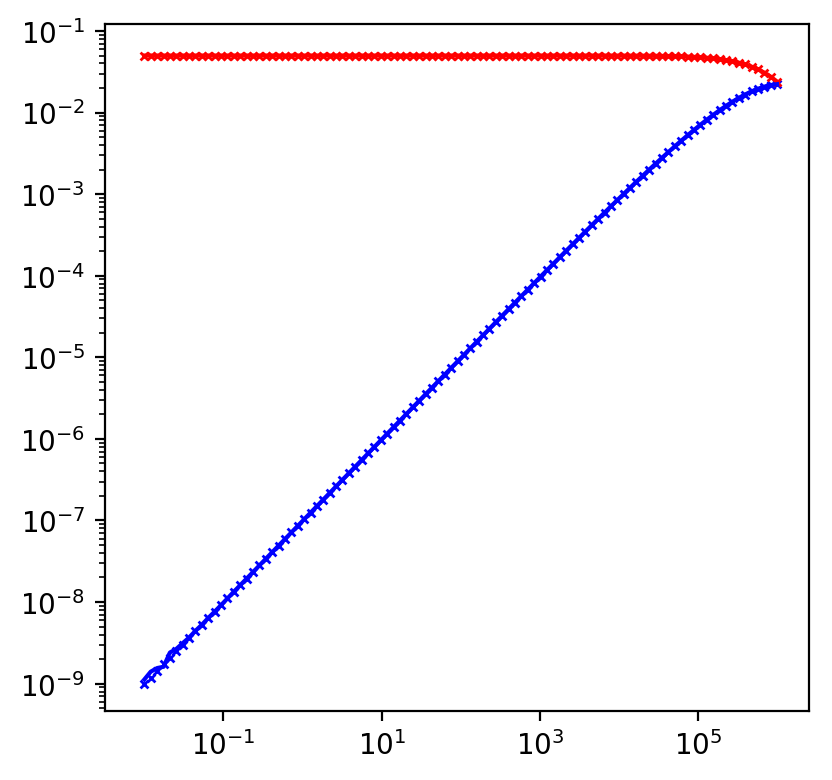

In [87]:
a = w1dem(EmB)